# PHASE 3 PROJECT: Terry Stops Analysis

## Business Understanding

# Objective
### The goal of this project is to predict whether an arrest was made following a Terry Stop. This is a binary classification problem, where the target variable is `Arrest Flag`. By building this model, we aim to identify the factors that contribute to arrests during such stops and to explore potential disparities related to race, gender, or other variables.

# Key Considerations:
### - Ethical Implications: This project uses sensitive information such as race and gender. Transparency in analysis and handling these features responsibly are critical.
### - Bias Awareness: Models and analyses must be evaluated for potential biases that could perpetuate systemic inequities.

# Key Questions:
### 1. What features (e.g., time of day, weapon presence, officer demographics) are most predictive of arrests?

## Importing libraries

In [1]:
# Load Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from imblearn.over_sampling import SMOTE

In [2]:
# Load the dataset
data = pd.read_csv("Terry_Stops_20241220.csv")

In [3]:
# Display the first few rows of the dataset
print("Dataset Overview:\n")
data.head()

Dataset Overview:



,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,...,Reported Time,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat
0,56 and Above,-1,20160000215451,166658,Arrest,NaN,6339,1969,M,White,...,11:30:00.0000000,SUSPICIOUS STOP - OFFICER INITIATED ONVIEW,--WARRANT SERVICES - FELONY,ONVIEW,NORTH PCT OPS - ACT DAY,N,N,North,N,N2
1,-,-1,20150000003630,64264,Field Contact,Firearm Other,6040,1952,M,White,...,02:01:00.0000000,-,-,-,SOUTHWEST PCT 3RD W - WILLIAM - PLATOON 2,N,Y,-,-,-
2,1 - 17,-1,20160000167765,154778,Offense Report,NaN,6294,1970,M,White,...,02:31:00.0000000,DISTURBANCE,--DISTURBANCE - OTHER,ONVIEW,EAST PCT 3RD W - CHARLIE - PLATOON 2,N,N,East,C,C2
3,26 - 35,-1,20160000003468,182803,Field Contact,NaN,6227,1971,M,White,...,13:07:00.0000000,-,-,-,EAST PCT 2ND W - CHARLIE - PLATOON 2,N,N,South,R,R1
4,18 - 25,-1,20170000374711,316838,Offense Report,NaN,6953,1968,M,White,...,18:19:00.0000000,DISTURBANCE,--PROWLER - TRESPASS,911,NORTH PCT 2ND W - NORA (JOHN) - PLATOON 1,N,N,North,N,N3


In [4]:
# Display basic information about the dataset
print("Dataset Shape:", data.shape)
print("\nColumn Names and Types:", data.info())

Dataset Shape: (62191, 23)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62191 entries, 0 to 62190
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Subject Age Group         62191 non-null  object
 1   Subject ID                62191 non-null  int64 
 2   GO / SC Num               62191 non-null  int64 
 3   Terry Stop ID             62191 non-null  int64 
 4   Stop Resolution           62191 non-null  object
 5   Weapon Type               29626 non-null  object
 6   Officer ID                62191 non-null  object
 7   Officer YOB               62191 non-null  int64 
 8   Officer Gender            62191 non-null  object
 9   Officer Race              62191 non-null  object
 10  Subject Perceived Race    62191 non-null  object
 11  Subject Perceived Gender  62191 non-null  object
 12  Reported Date             62191 non-null  object
 13  Reported Time             62191 non-null  object


In [5]:
# Drop initial columns that I consider irrelevant in this analysis.
data.drop(columns= ['Subject ID', 'GO / SC Num', 'Terry Stop ID', 'Officer ID', 'Sector', 'Beat'],inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62191 entries, 0 to 62190
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Subject Age Group         62191 non-null  object
 1   Stop Resolution           62191 non-null  object
 2   Weapon Type               29626 non-null  object
 3   Officer YOB               62191 non-null  int64 
 4   Officer Gender            62191 non-null  object
 5   Officer Race              62191 non-null  object
 6   Subject Perceived Race    62191 non-null  object
 7   Subject Perceived Gender  62191 non-null  object
 8   Reported Date             62191 non-null  object
 9   Reported Time             62191 non-null  object
 10  Initial Call Type         62191 non-null  object
 11  Final Call Type           62191 non-null  object
 12  Call Type                 62191 non-null  object
 13  Officer Squad             61630 non-null  object
 14  Arrest Flag           

In [6]:
for column in data.columns:
    print(column, '\n')
    print(data[column].value_counts())
    print('_________')
    print('_________')

Subject Age Group 

Subject Age Group
26 - 35         20769
36 - 45         13966
18 - 25         11739
46 - 55          7878
56 and Above     3273
1 - 17           2319
-                2247
Name: count, dtype: int64
_________
_________
Stop Resolution 

Stop Resolution
Field Contact               30376
Offense Report              15824
Arrest                      15042
Referred for Prosecution      728
Citation / Infraction         221
Name: count, dtype: int64
_________
_________
Weapon Type 

Weapon Type
-                                       25667
Lethal Cutting Instrument                1482
Knife/Cutting/Stabbing Instrument        1385
Handgun                                   406
Blunt Object/Striking Implement           181
Firearm                                   116
Firearm Other                             100
Other Firearm                              80
Mace/Pepper Spray                          59
Club, Blackjack, Brass Knuckles            49
None/Not Applicable       

In [7]:
# check for null values
data.isna().sum()

Subject Age Group               0
Stop Resolution                 0
Weapon Type                 32565
Officer YOB                     0
Officer Gender                  0
Officer Race                    0
Subject Perceived Race          0
Subject Perceived Gender        0
Reported Date                   0
Reported Time                   0
Initial Call Type               0
Final Call Type                 0
Call Type                       0
Officer Squad                 561
Arrest Flag                     0
Frisk Flag                      0
Precinct                        0
dtype: int64

In [8]:
# check for the column with missing falue and check whether it is relevant to this analysis
data['Officer Squad'].value_counts()


Officer Squad
TRAINING - FIELD TRAINING SQUAD            6613
WEST PCT 1ST W - DAVID - PLATOON 1         1706
WEST PCT 3RD W - KING - PLATOON 1          1393
WEST PCT 1ST W - KING - PLATOON 1          1310
SOUTHWEST PCT 2ND W - FRANK - PLATOON 2    1282
                                           ... 
WEST PCT 2ND W - MARY                         1
NORTH PCT 3RD W - LINCOLN                     1
TRAF - MOTORCYCLE UNIT - T3 SQUAD             1
CSI SQUAD                                     1
TRAINING - ADVANCED UNIT ADMINISTRATION       1
Name: count, Length: 273, dtype: int64

In [9]:
data.drop(columns= ['Officer Squad'], inplace=True)

### Feature Engineering on Target Varibale

In [10]:
# Analyze Target Variable: Arrest Flag
print("\nTarget Variable Analysis: Arrest Flag")
print(data['Arrest Flag'].value_counts())
print("\nClass Distribution (%):")
print(data['Arrest Flag'].value_counts(normalize=True) * 100)


Target Variable Analysis: Arrest Flag
Arrest Flag
N    55357
Y     6834
Name: count, dtype: int64

Class Distribution (%):
Arrest Flag
N    89.011272
Y    10.988728
Name: proportion, dtype: float64


In [11]:
# Analyze Target Variable: Stop Resolution
print("\nTarget Variable Analysis: Stop Resolution")
print(data['Stop Resolution'].value_counts())
print("\nClass Distribution (%):")
print(data['Stop Resolution'].value_counts(normalize=True) * 100)


Target Variable Analysis: Stop Resolution
Stop Resolution
Field Contact               30376
Offense Report              15824
Arrest                      15042
Referred for Prosecution      728
Citation / Infraction         221
Name: count, dtype: int64

Class Distribution (%):
Stop Resolution
Field Contact               48.843080
Offense Report              25.444196
Arrest                      24.186779
Referred for Prosecution     1.170587
Citation / Infraction        0.355357
Name: proportion, dtype: float64


### based on the information we have about the terry stop arrest, it is not a formal arrest Thus we have tonot that the stop resolution may not be relevant in our target variable. 

In [12]:
# Reduce the number of values on the stop resolution column
Arrest_Resolution = {
    'Field Contact': 'No Arrest',
    'Citation / Infraction': 'No Arrest',
    'Offense Report': 'No Arrest',
    'Arrest': 'Arrest',
    'Referred for Prosecution': 'No Arrest'
}

data['Arrest Stop Resolution'] = data['Stop Resolution'].map(Arrest_Resolution)
print("\nTarget Variable Analysis: Arrest Stop Resolution")
print(data['Arrest Stop Resolution'].value_counts())
print("\nClass Distribution (%):")
print(data['Arrest Stop Resolution'].value_counts(normalize=True) * 100)
data.drop(columns= ['Stop Resolution'], inplace=True)


Target Variable Analysis: Arrest Stop Resolution
Arrest Stop Resolution
No Arrest    47149
Arrest       15042
Name: count, dtype: int64

Class Distribution (%):
Arrest Stop Resolution
No Arrest    75.813221
Arrest       24.186779
Name: proportion, dtype: float64


In [13]:
# Create the 'Terry stop arrest' column
data['Terry stop arrest'] = (
    (data['Arrest Stop Resolution'] == 'Arrest') | (data['Arrest Flag'] == 'Y')
).astype(int)

print("\nTarget Variable Analysis: Terry stop arrest")
print(data['Terry stop arrest'].value_counts())
print("\nClass Distribution (%):")
print(data['Terry stop arrest'].value_counts(normalize=True) * 100)


Target Variable Analysis: Terry stop arrest
Terry stop arrest
0    47147
1    15044
Name: count, dtype: int64

Class Distribution (%):
Terry stop arrest
0    75.810005
1    24.189995
Name: proportion, dtype: float64


In [14]:
data.head()

,Subject Age Group,Weapon Type,Officer YOB,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Reported Date,Reported Time,Initial Call Type,Final Call Type,Call Type,Arrest Flag,Frisk Flag,Precinct,Arrest Stop Resolution,Terry stop arrest
0,56 and Above,NaN,1969,M,White,White,Male,2016-06-17T00:00:00Z,11:30:00.0000000,SUSPICIOUS STOP - OFFICER INITIATED ONVIEW,--WARRANT SERVICES - FELONY,ONVIEW,N,N,North,Arrest,1
1,-,Firearm Other,1952,M,White,Unknown,Unable to Determine,2015-07-18T00:00:00Z,02:01:00.0000000,-,-,-,N,Y,-,No Arrest,0
2,1 - 17,NaN,1970,M,White,White,Male,2016-05-14T00:00:00Z,02:31:00.0000000,DISTURBANCE,--DISTURBANCE - OTHER,ONVIEW,N,N,East,No Arrest,0
3,26 - 35,NaN,1971,M,White,White,Male,2016-08-12T00:00:00Z,13:07:00.0000000,-,-,-,N,N,South,No Arrest,0
4,18 - 25,NaN,1968,M,White,Asian,Male,2017-10-08T00:00:00Z,18:19:00.0000000,DISTURBANCE,--PROWLER - TRESPASS,911,N,N,North,No Arrest,0


In [15]:
# Normalize the Officer Age column (derived from Officer YOB)
current_year = pd.Timestamp.now().year
data['Officer Age'] = current_year - data['Officer YOB']

# Replace outliers (above 75 years) with the mean of ages <= 75
officer_age_mean = data.loc[data['Officer Age'] <= 75, 'Officer Age'].mean()
data['Officer Age'] = data['Officer Age'].apply(lambda x: round(officer_age_mean) if x > 75 else x)
data.drop(columns=['Officer YOB'], inplace= True)

In [16]:
# Parse Reported Date into broader categories (example: year, month, day of week)
data['Reported Date'] = pd.to_datetime(data['Reported Date'], errors='coerce')
data['Reported Year'] = data['Reported Date'].dt.year
data['Reported Month'] = data['Reported Date'].dt.month
# data['Reported Date'] = data['Reported Date'].dt.date

data['Reported DayOfWeek'] = data['Reported Date'].dt.dayofweek
data.drop( columns=['Reported Date'], inplace= True)

In [17]:
# Map numbers to month names
month_mapping = {
    1: "January", 2: "February", 3: "March", 4: "April", 5: "May", 6: "June",
    7: "July", 8: "August", 9: "September", 10: "October", 11: "November", 12: "December"
}

# Apply the mapping to the 'Reported Month' column
data['Reported Month'] = data['Reported Month'].map(month_mapping)

In [18]:
day_mapping = {
    0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday",
    4: "Friday", 5: "Saturday", 6: "Sunday"
}

# Apply the mapping to the 'Reported DayOfWeek' column
data['Reported DayOfWeek'] = data['Reported DayOfWeek'].map(day_mapping)

In [19]:
# Clean the 'Reported Time' column to extract hours and minutes
data['Reported Time'] = data['Reported Time'].str.extract(r'(\d{2}:\d{2})')
data['Reported Hour'] = pd.to_datetime(data['Reported Time'], format='%H:%M', errors='coerce').dt.hour
data.drop(columns=['Reported Time'], inplace=True)

In [20]:
data.head()

,Subject Age Group,Weapon Type,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,Final Call Type,Call Type,Arrest Flag,Frisk Flag,Precinct,Arrest Stop Resolution,Terry stop arrest,Officer Age,Reported Year,Reported Month,Reported DayOfWeek,Reported Hour
0,56 and Above,NaN,M,White,White,Male,SUSPICIOUS STOP - OFFICER INITIATED ONVIEW,--WARRANT SERVICES - FELONY,ONVIEW,N,N,North,Arrest,1,55,2016,June,Friday,11
1,-,Firearm Other,M,White,Unknown,Unable to Determine,-,-,-,N,Y,-,No Arrest,0,72,2015,July,Saturday,2
2,1 - 17,NaN,M,White,White,Male,DISTURBANCE,--DISTURBANCE - OTHER,ONVIEW,N,N,East,No Arrest,0,54,2016,May,Saturday,2
3,26 - 35,NaN,M,White,White,Male,-,-,-,N,N,South,No Arrest,0,53,2016,August,Friday,13
4,18 - 25,NaN,M,White,Asian,Male,DISTURBANCE,--PROWLER - TRESPASS,911,N,N,North,No Arrest,0,56,2017,October,Sunday,18


In [21]:
# Categorizing Weapon Type
def categorize_weapon(weapon):
    if weapon in ['None', 'None/Not Applicable']:
        return 'None'
    elif weapon == 'Unknown':
        return 'Uncertain'
    elif weapon in ['Lethal Cutting Instrument', 'Knife/Cutting/Stabbing Instrument']:
        return 'Sharp Weapon'
    elif weapon in ['Handgun', 'Rifle', 'Shotgun', 'Firearm', 'Firearm Other', 'Automatic Handgun']:
        return 'Firearm'
    elif weapon in ['Mace/Pepper Spray', 'Taser/Stun Gun', 'Blunt Object/Striking Implement']:
        return 'Non-lethal Weapon'
    else:
        return 'Other'

data['Weapon Type'] = data['Weapon Type'].apply(categorize_weapon)
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62191 entries, 0 to 62190
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Subject Age Group         62191 non-null  object
 1   Weapon Type               62191 non-null  object
 2   Officer Gender            62191 non-null  object
 3   Officer Race              62191 non-null  object
 4   Subject Perceived Race    62191 non-null  object
 5   Subject Perceived Gender  62191 non-null  object
 6   Initial Call Type         62191 non-null  object
 7   Final Call Type           62191 non-null  object
 8   Call Type                 62191 non-null  object
 9   Arrest Flag               62191 non-null  object
 10  Frisk Flag                62191 non-null  object
 11  Precinct                  62191 non-null  object
 12  Arrest Stop Resolution    62191 non-null  object
 13  Terry stop arrest         62191 non-null  int64 
 14  Officer Age           

In [22]:
# Replace "-" with "Unknown" in categorical columns
for col in data.columns:
    if data[col].dtype.name == 'category' or data[col].dtype == 'object':
        data[col] = data[col].replace('-', 'Unknown')

## EDA

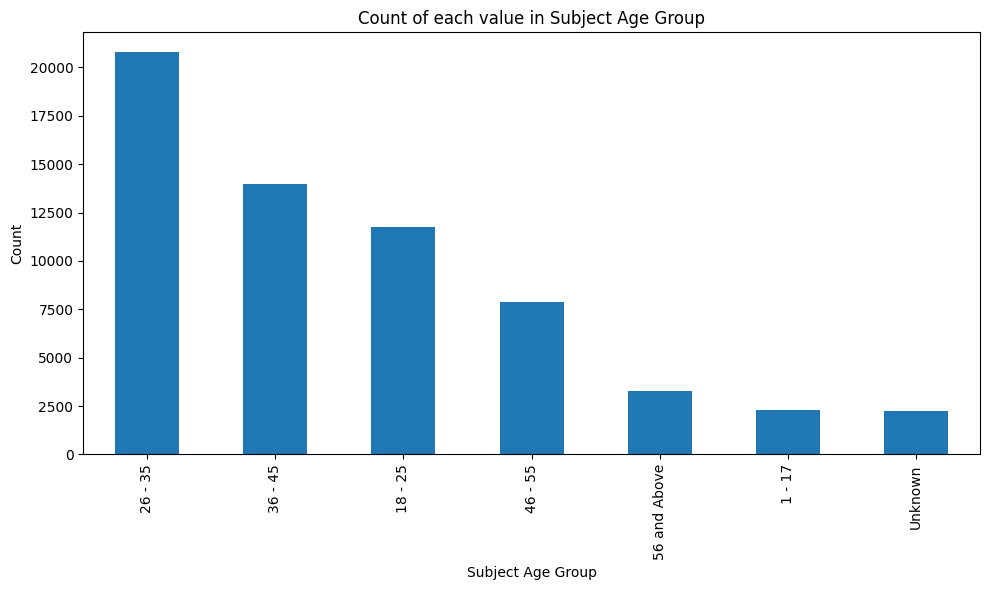

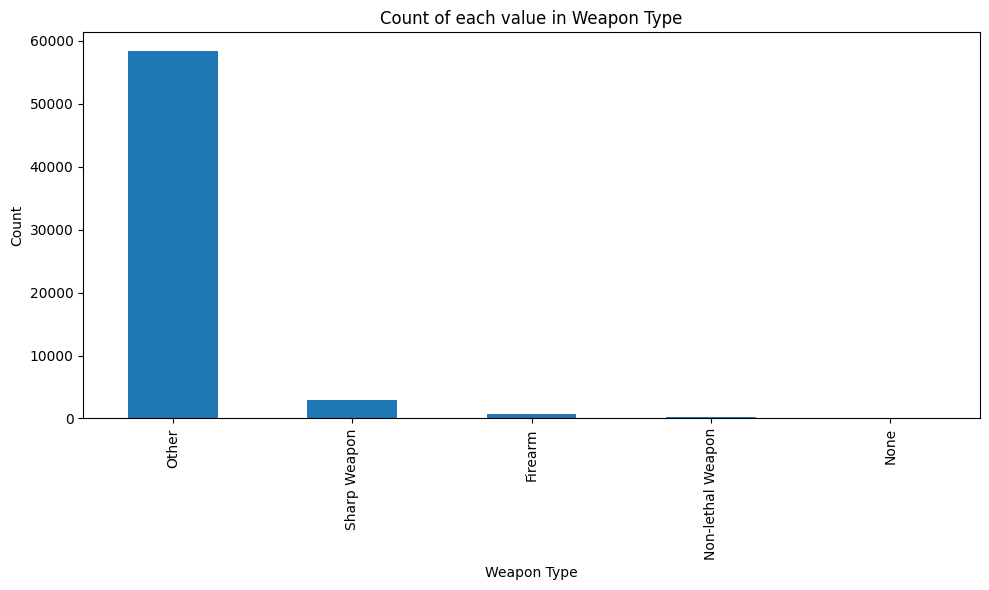

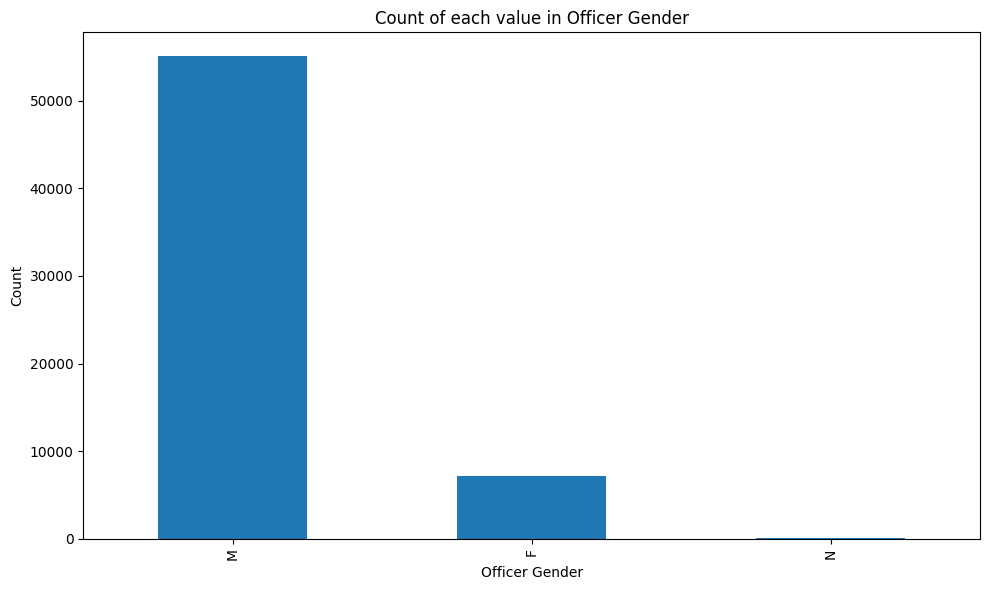

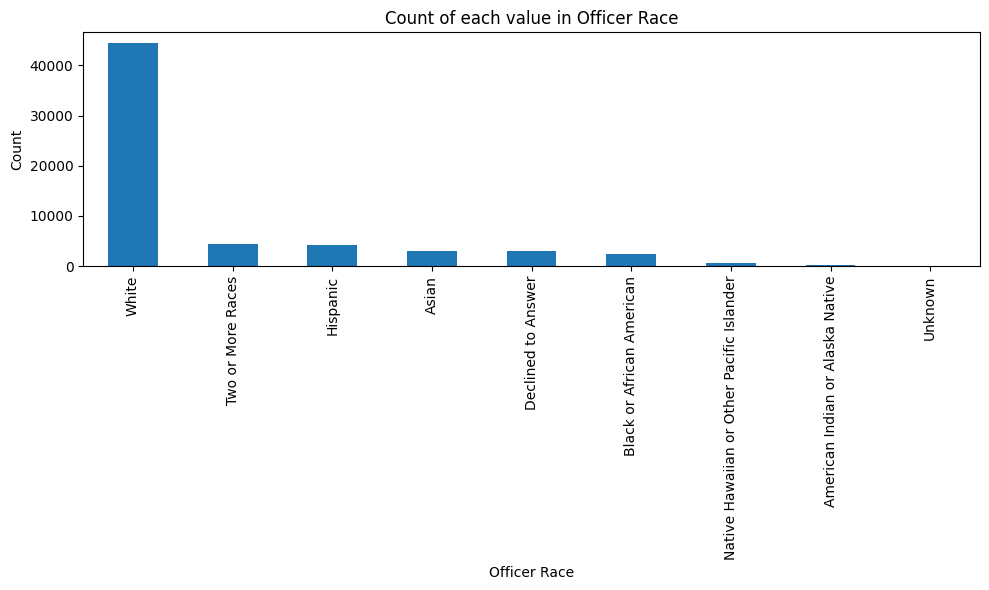

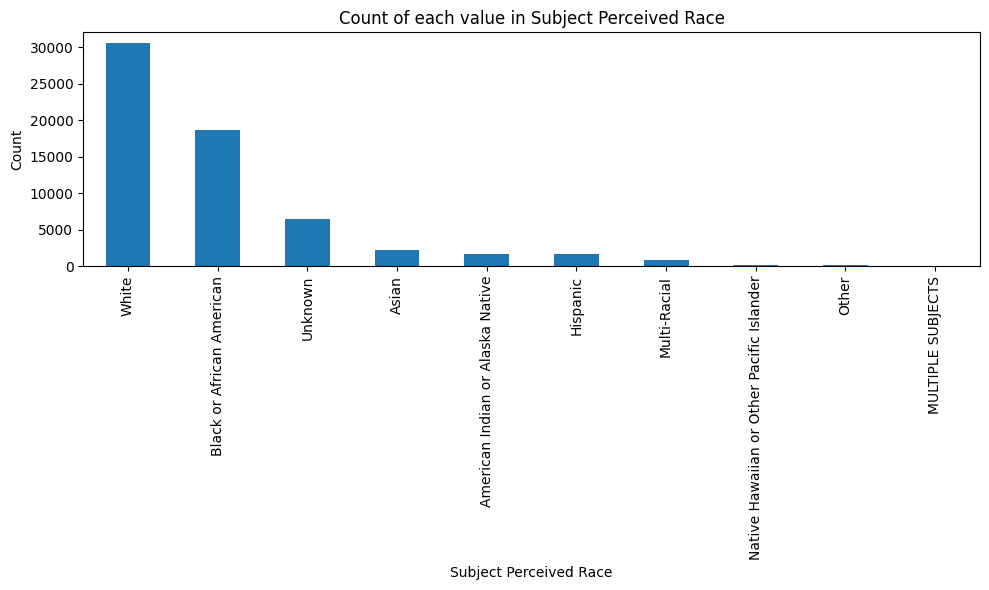

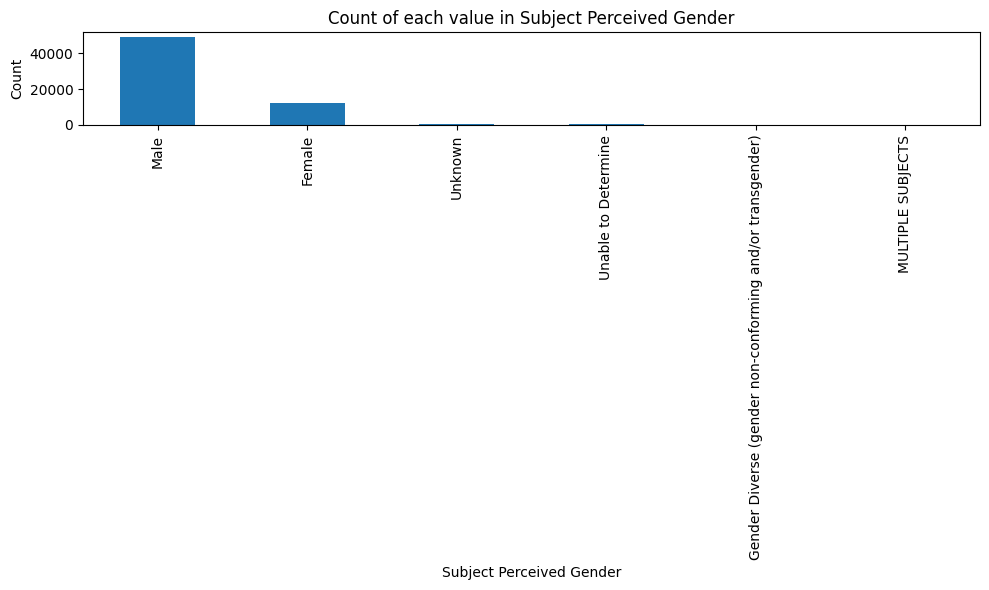

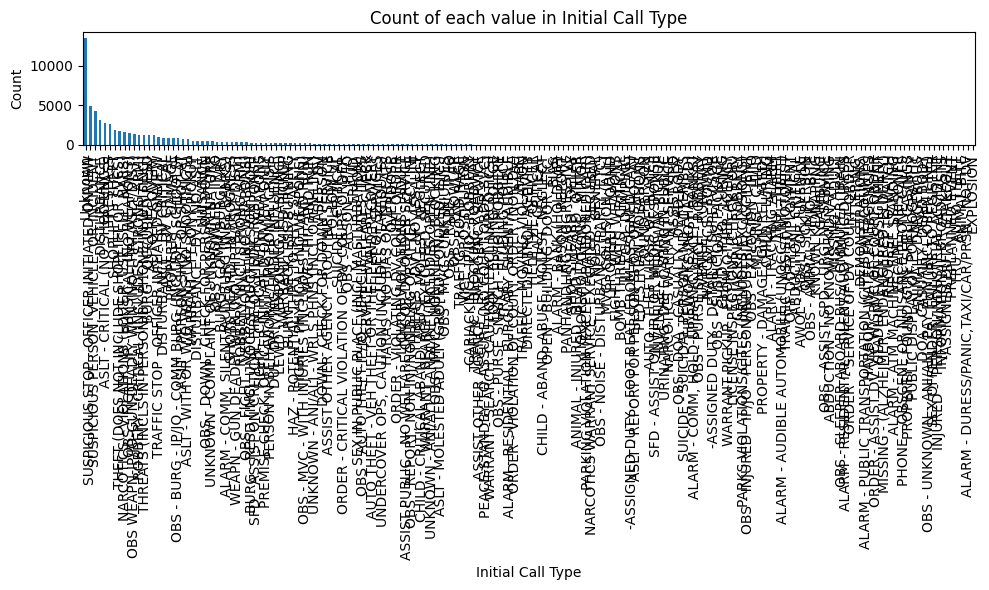

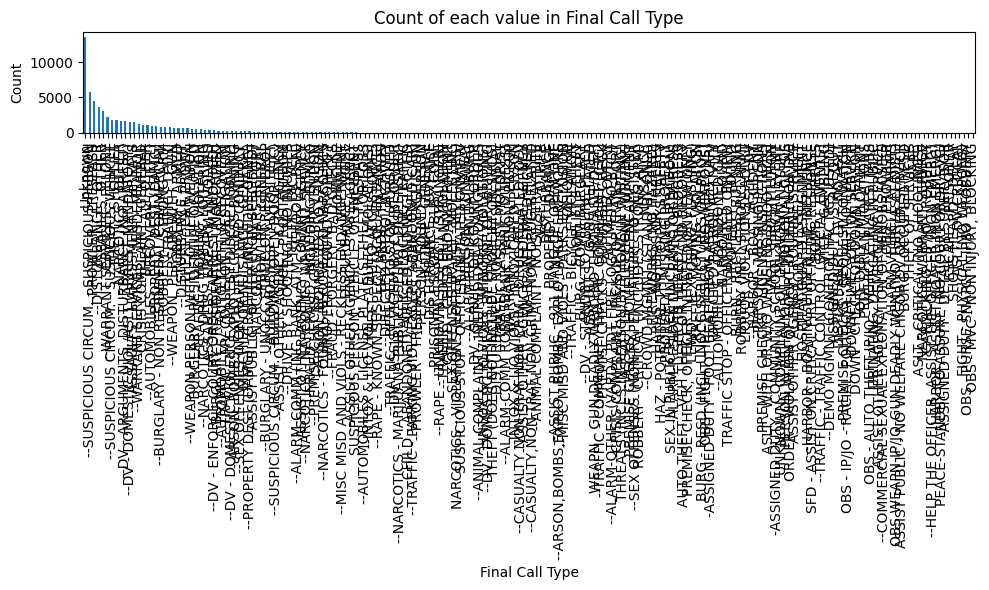

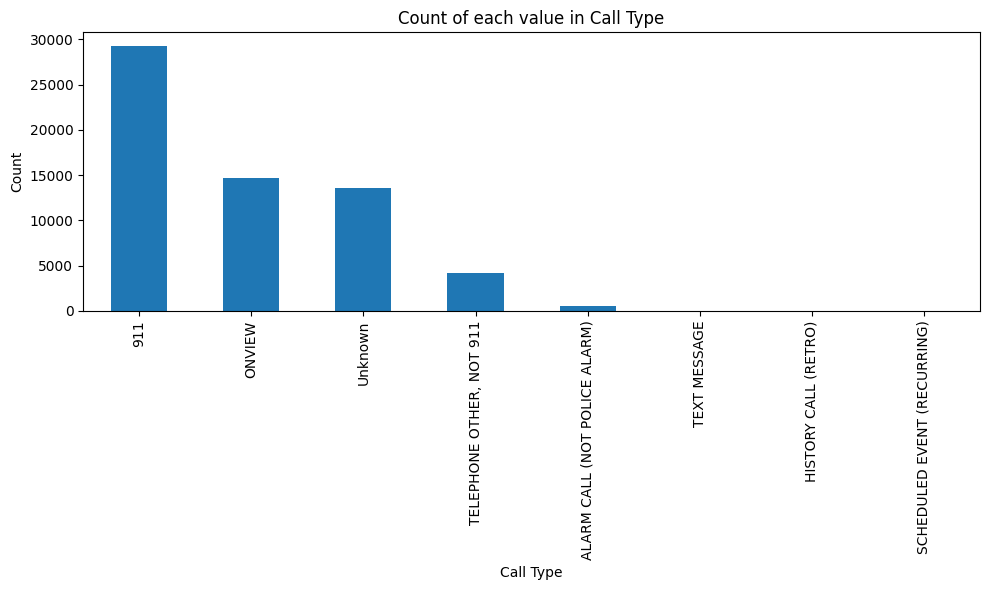

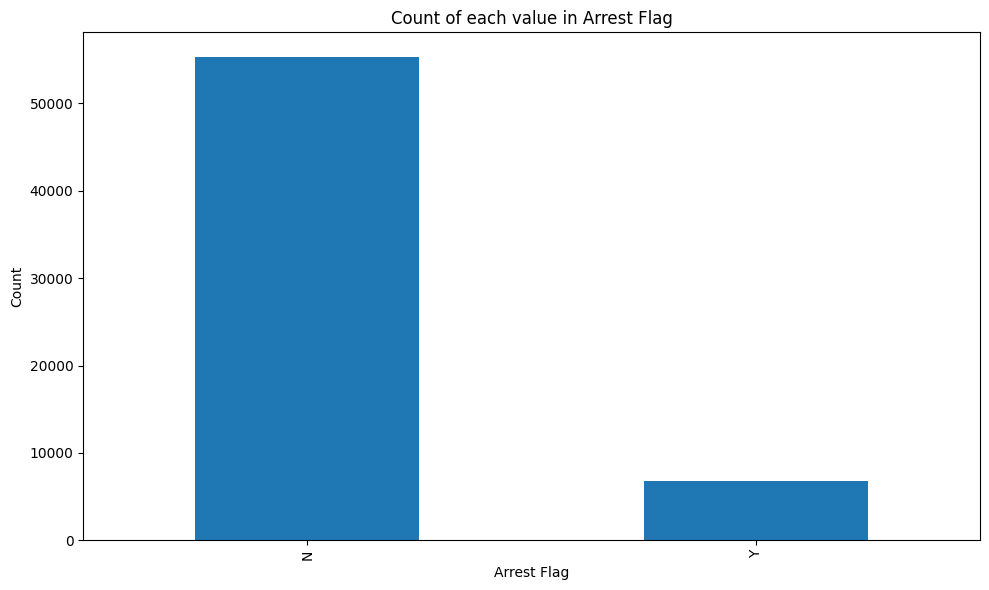

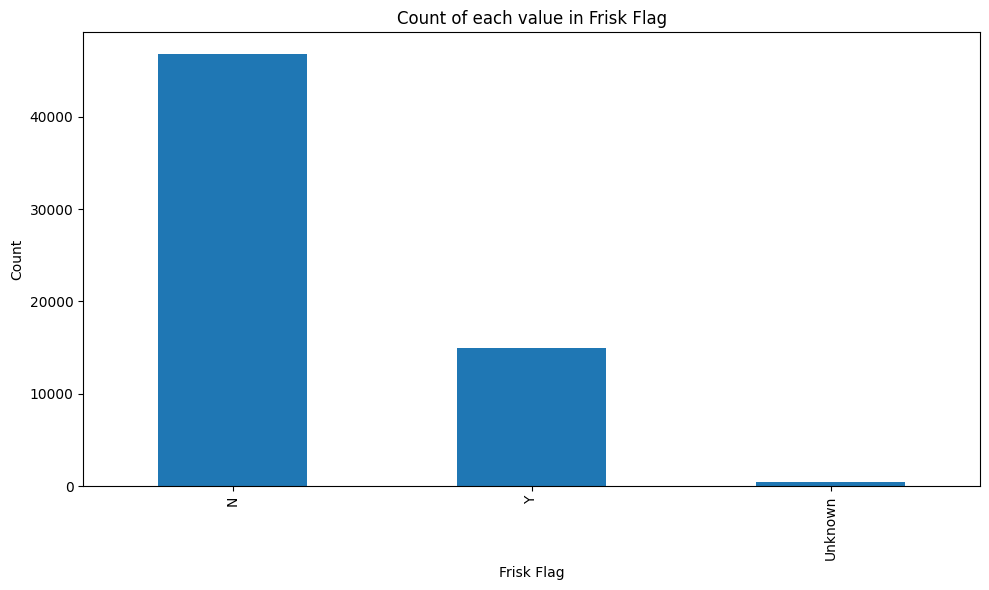

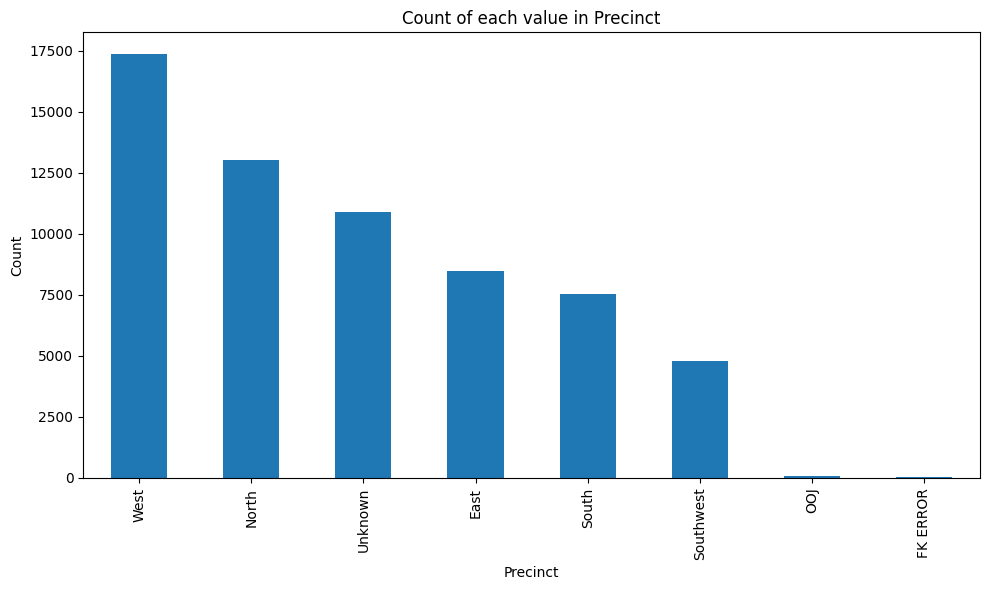

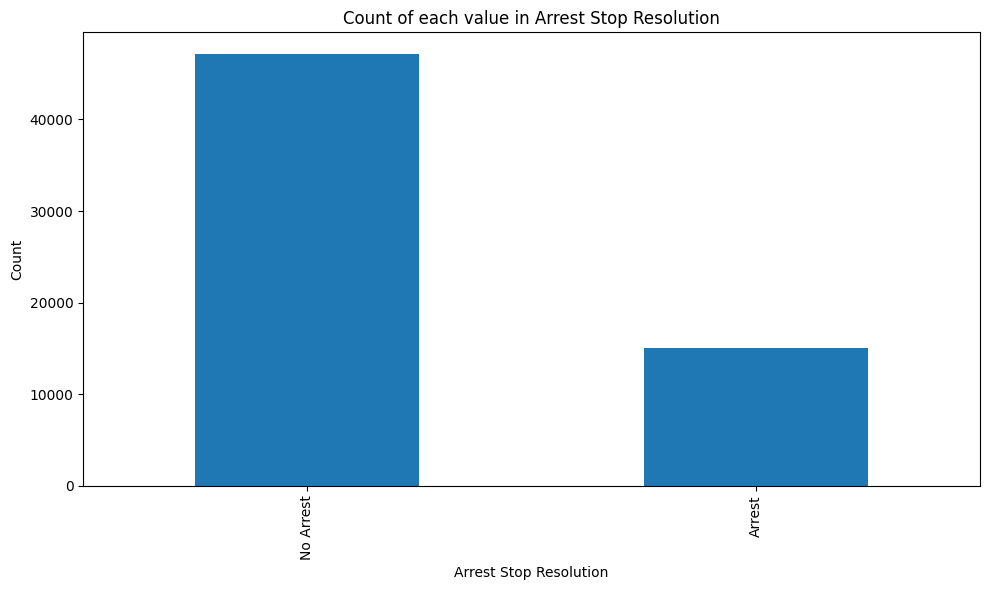

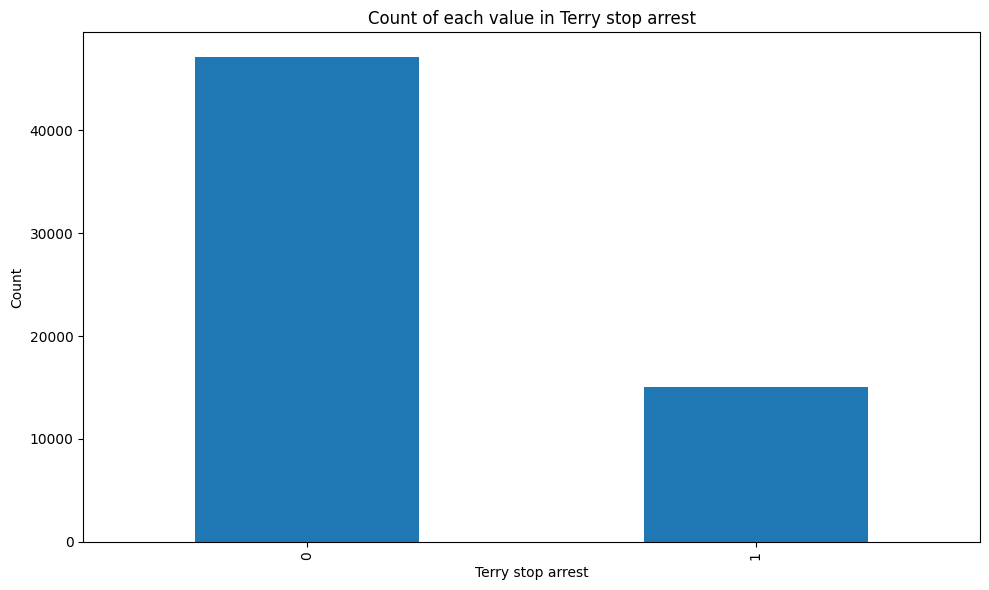

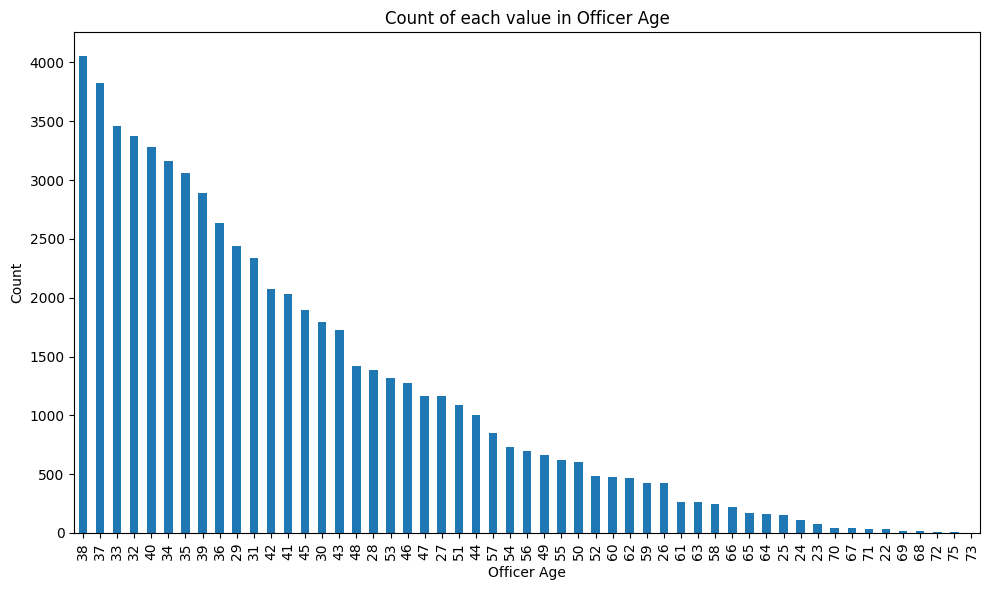

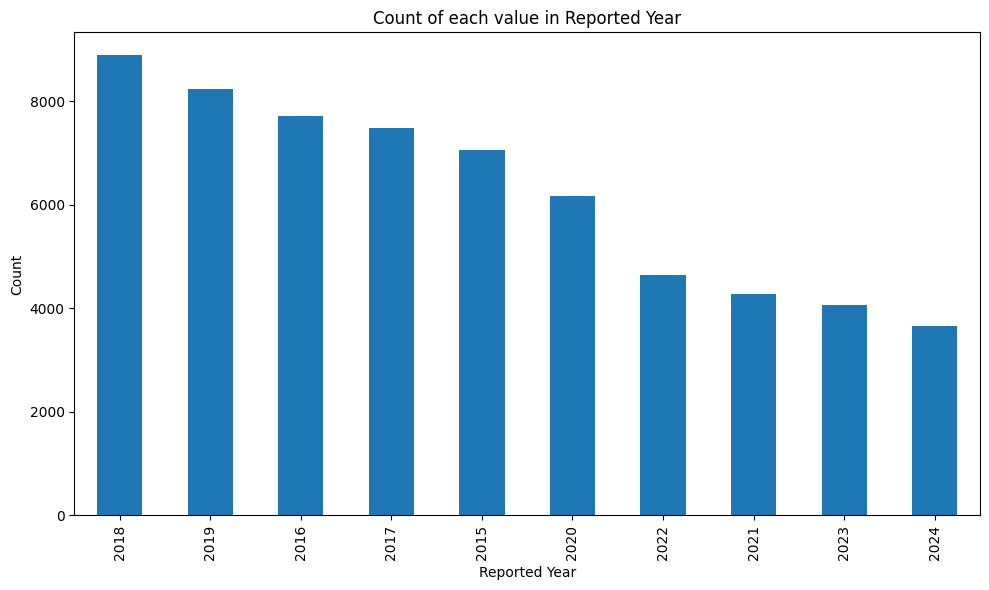

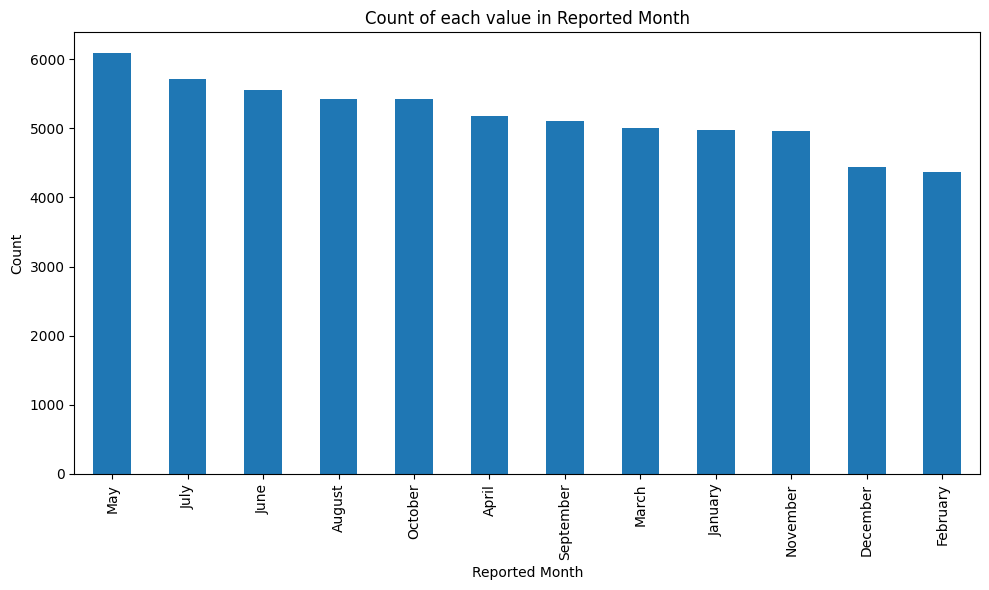

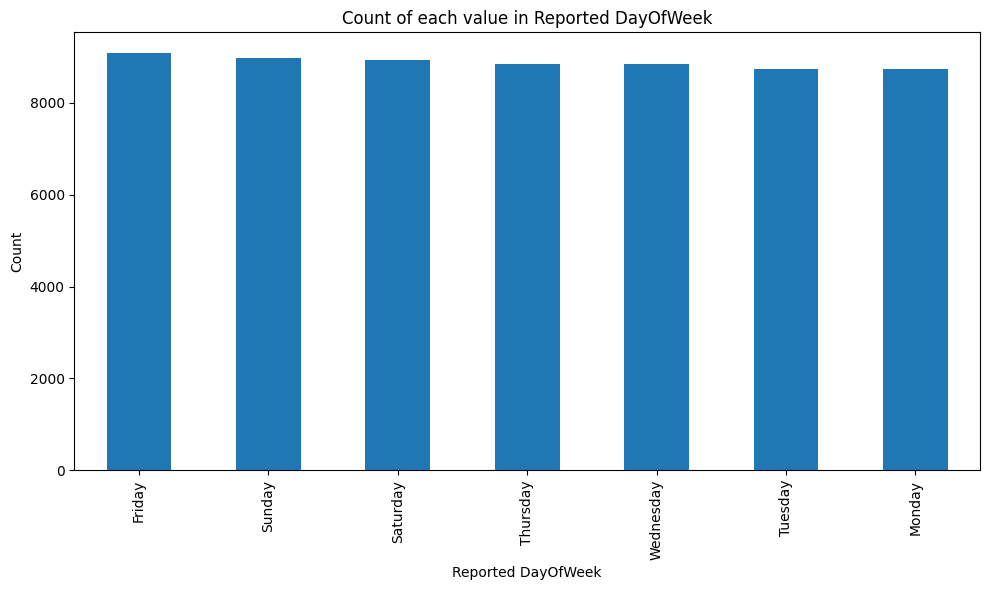

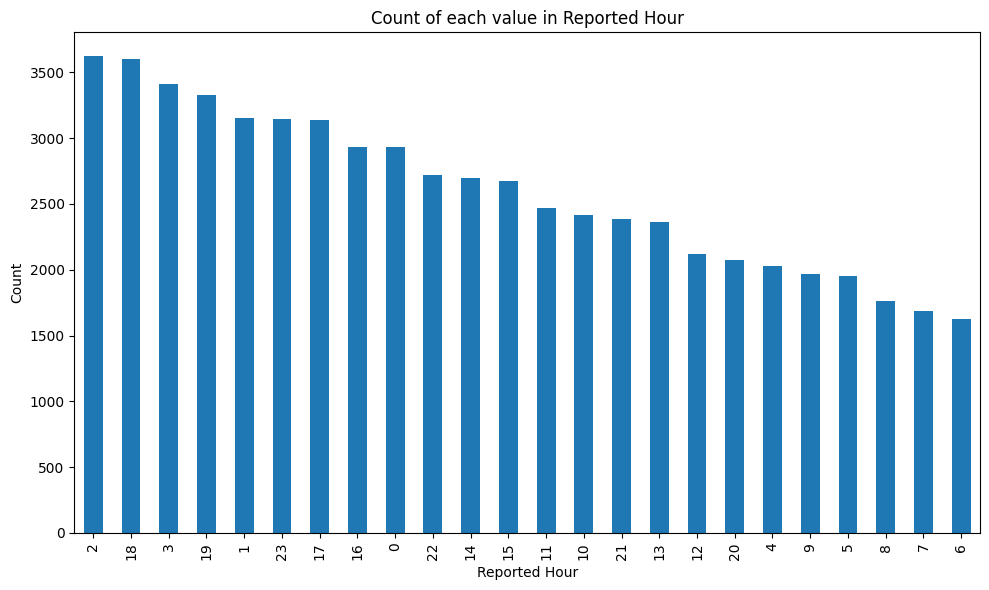

In [23]:
# Plot the count of each column
columns_to_plot = data.columns

for column in columns_to_plot:
    plt.figure(figsize=(10, 6))
    data[column].value_counts().plot(kind='bar')
    plt.title(f"Count of each value in {column}")
    plt.xlabel(column)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

### After conducting visualization on the remaining columns, I feel that it is essential that I drop the Ínitial Call Type' and the 'Final Call Type' columns.

In [24]:
data.drop(columns=['Initial Call Type', 'Final Call Type'], inplace= True)

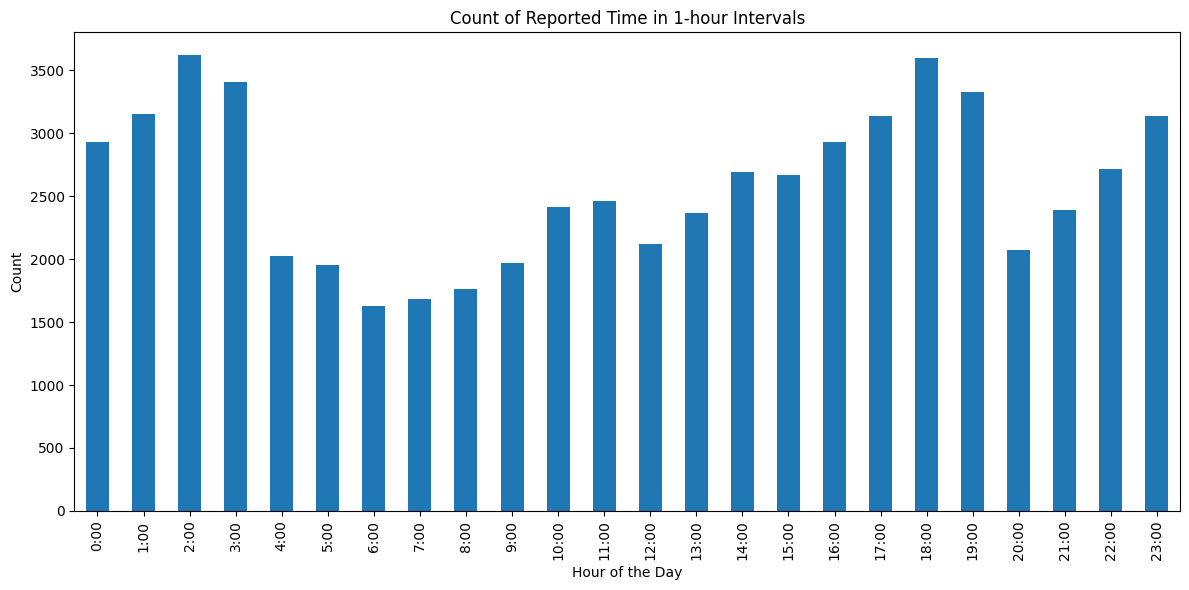

In [25]:


# Group by hour and plot
plt.figure(figsize=(12, 6))
data['Reported Hour'].value_counts(sort=False).sort_index().plot(kind='bar')
plt.title("Count of Reported Time in 1-hour Intervals")
plt.xlabel("Hour of the Day")
plt.ylabel("Count")
plt.xticks(ticks=range(0, 24), labels=[f"{hour}:00" for hour in range(24)])
plt.tight_layout()
plt.show()

In [26]:
data.head()

,Subject Age Group,Weapon Type,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Call Type,Arrest Flag,Frisk Flag,Precinct,Arrest Stop Resolution,Terry stop arrest,Officer Age,Reported Year,Reported Month,Reported DayOfWeek,Reported Hour
0,56 and Above,Other,M,White,White,Male,ONVIEW,N,N,North,Arrest,1,55,2016,June,Friday,11
1,Unknown,Firearm,M,White,Unknown,Unable to Determine,Unknown,N,Y,Unknown,No Arrest,0,72,2015,July,Saturday,2
2,1 - 17,Other,M,White,White,Male,ONVIEW,N,N,East,No Arrest,0,54,2016,May,Saturday,2
3,26 - 35,Other,M,White,White,Male,Unknown,N,N,South,No Arrest,0,53,2016,August,Friday,13
4,18 - 25,Other,M,White,Asian,Male,911,N,N,North,No Arrest,0,56,2017,October,Sunday,18


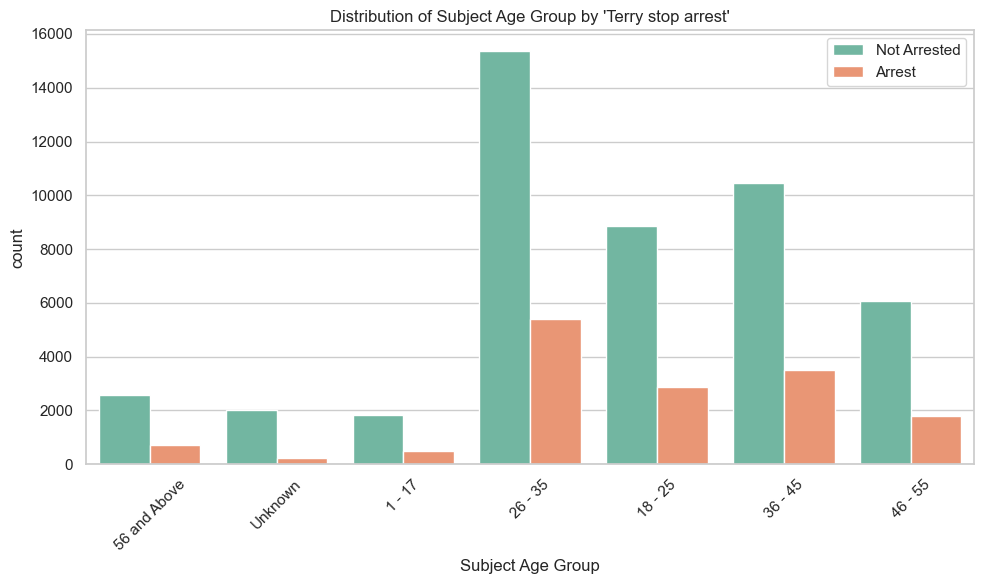

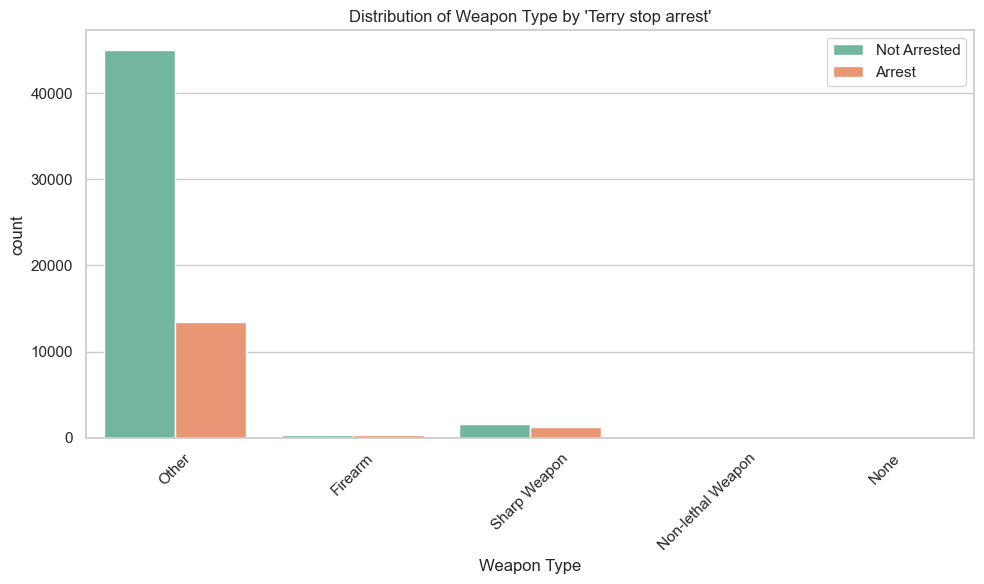

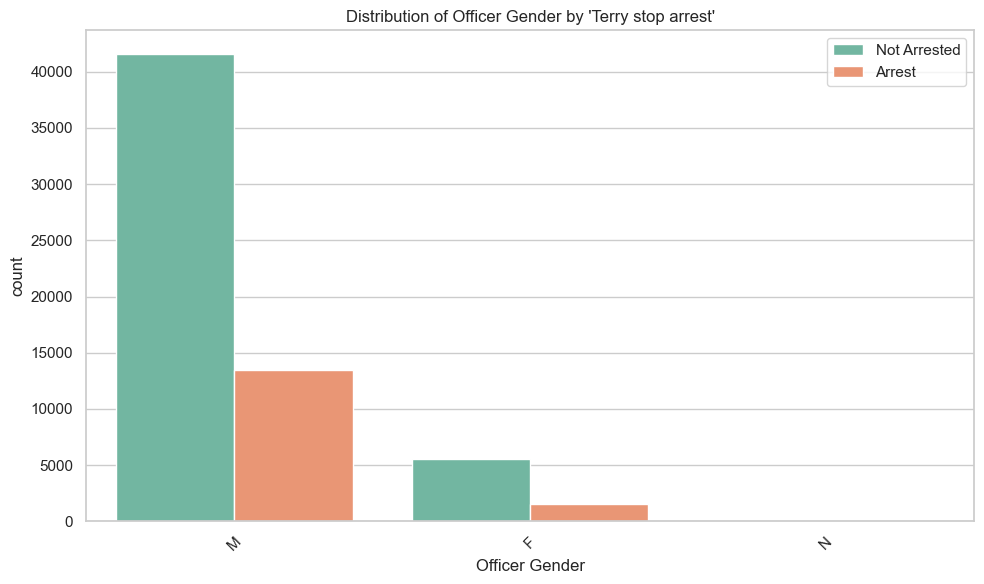

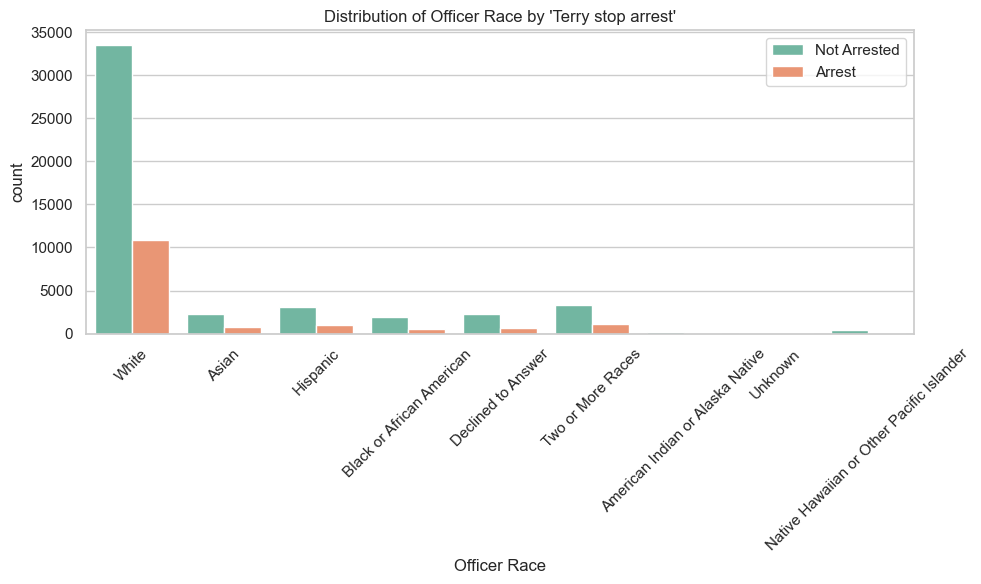

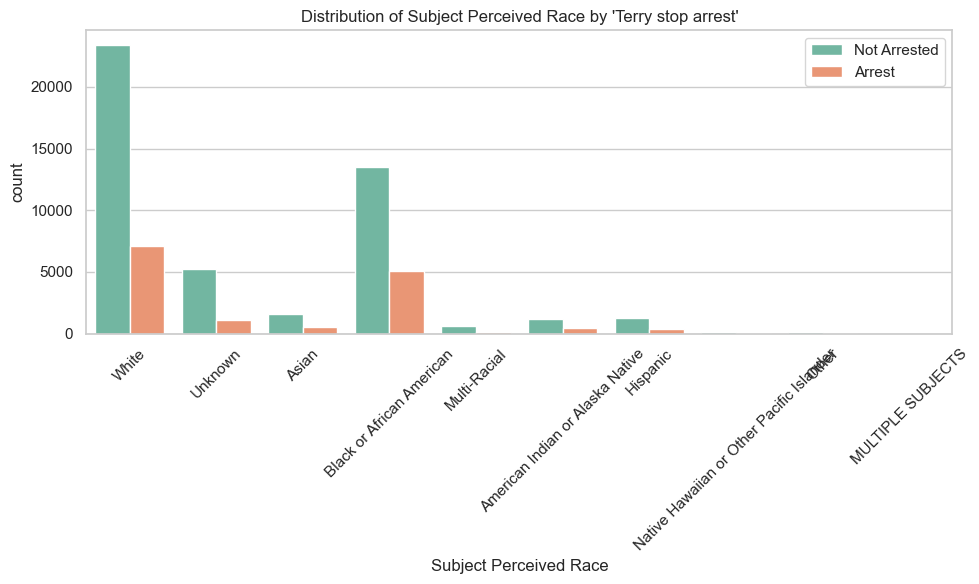

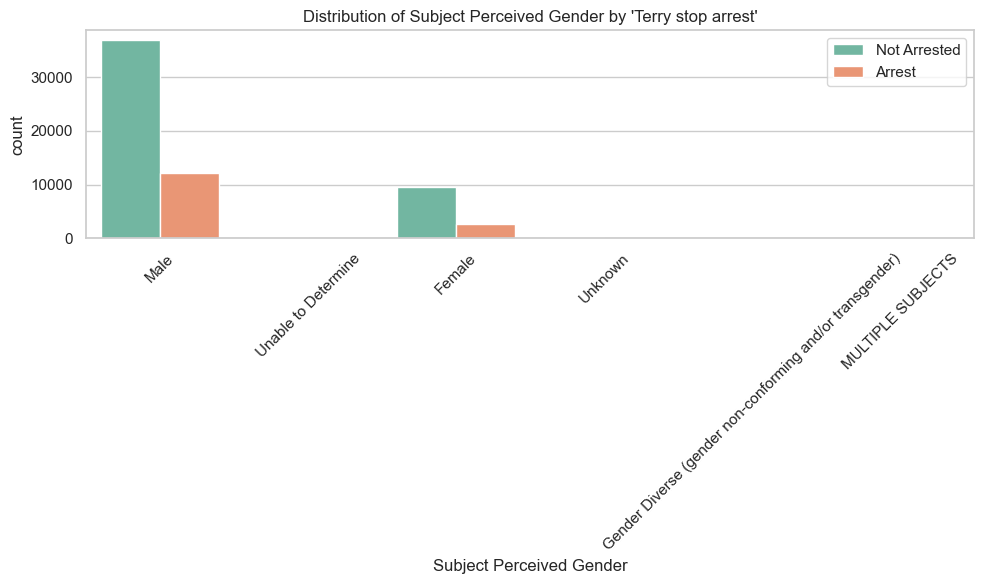

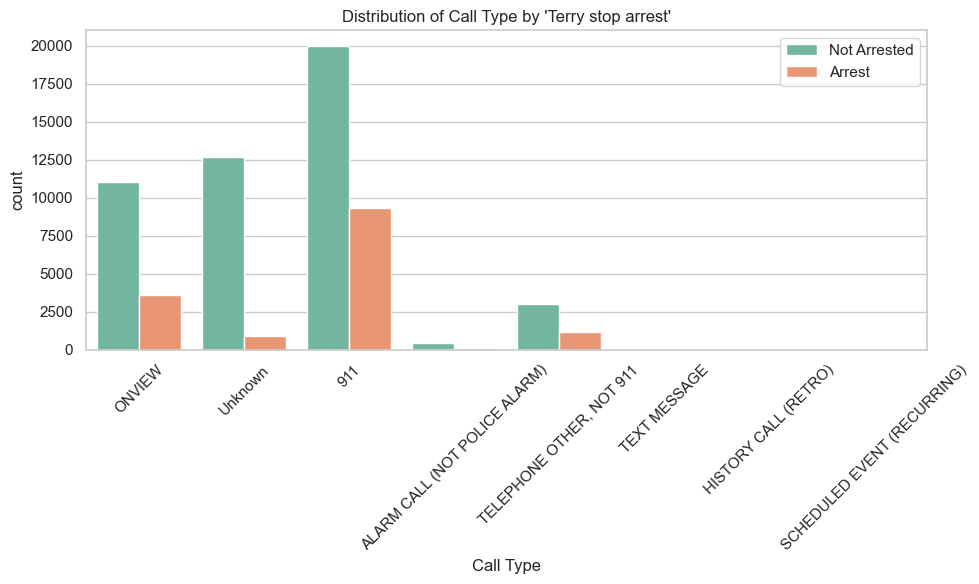

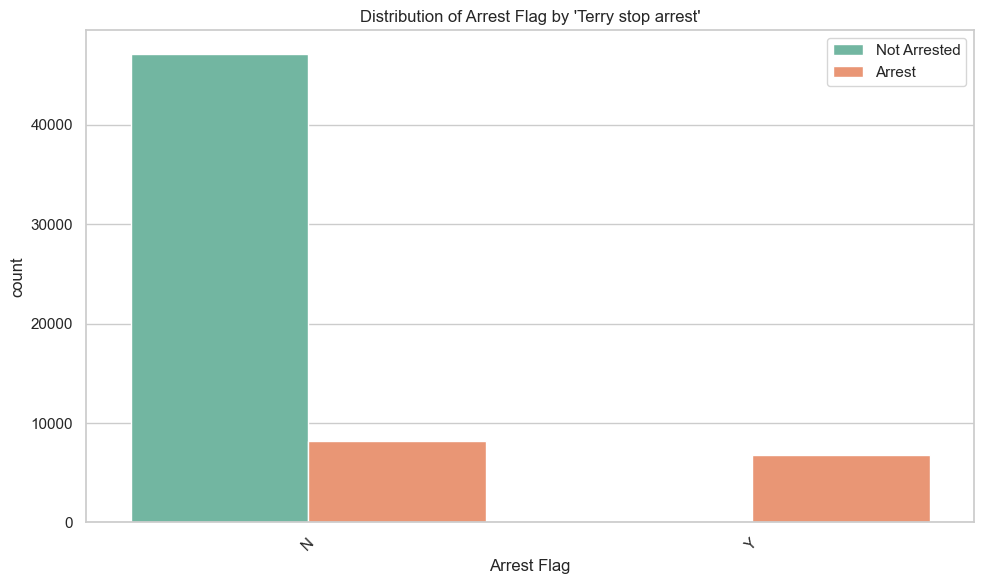

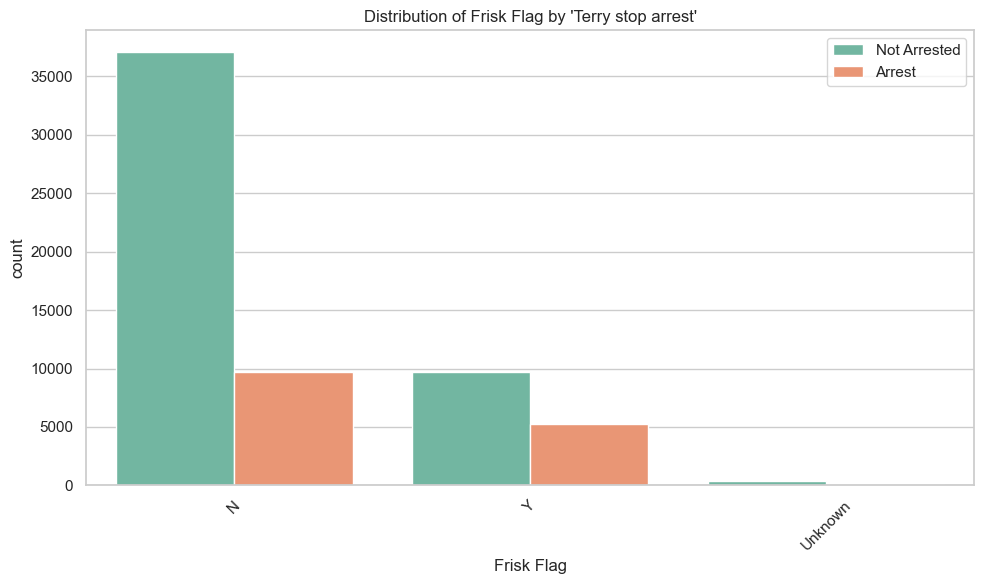

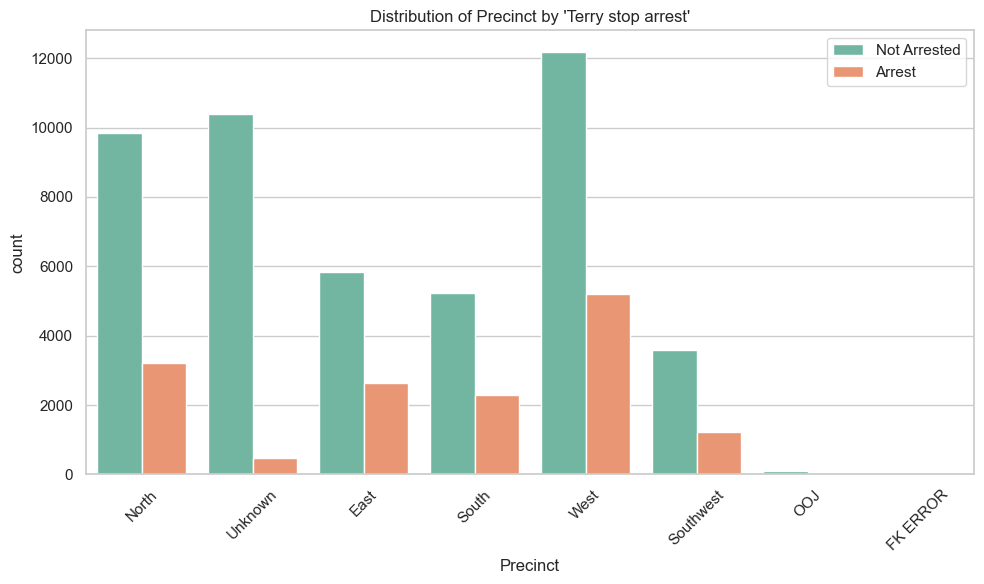

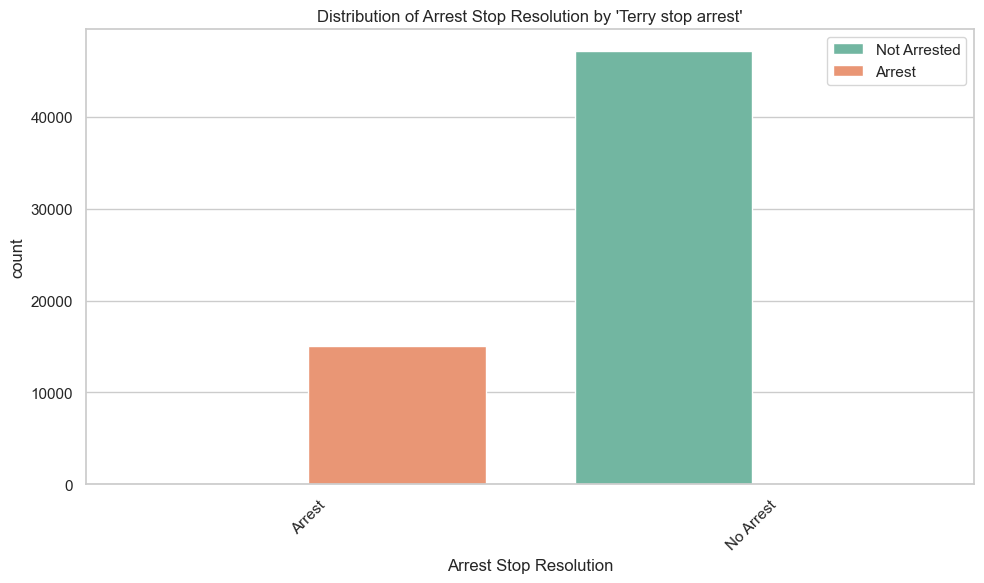

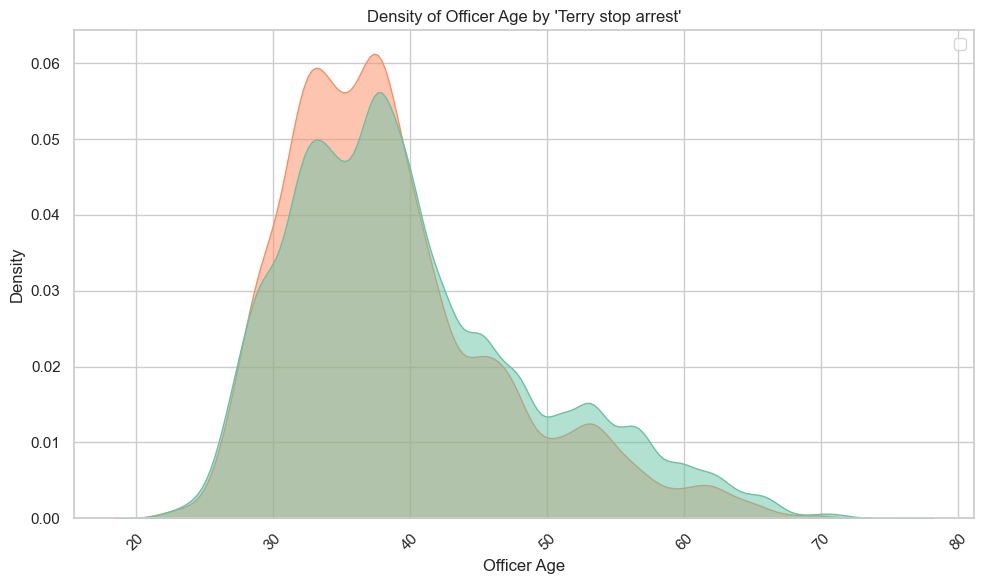

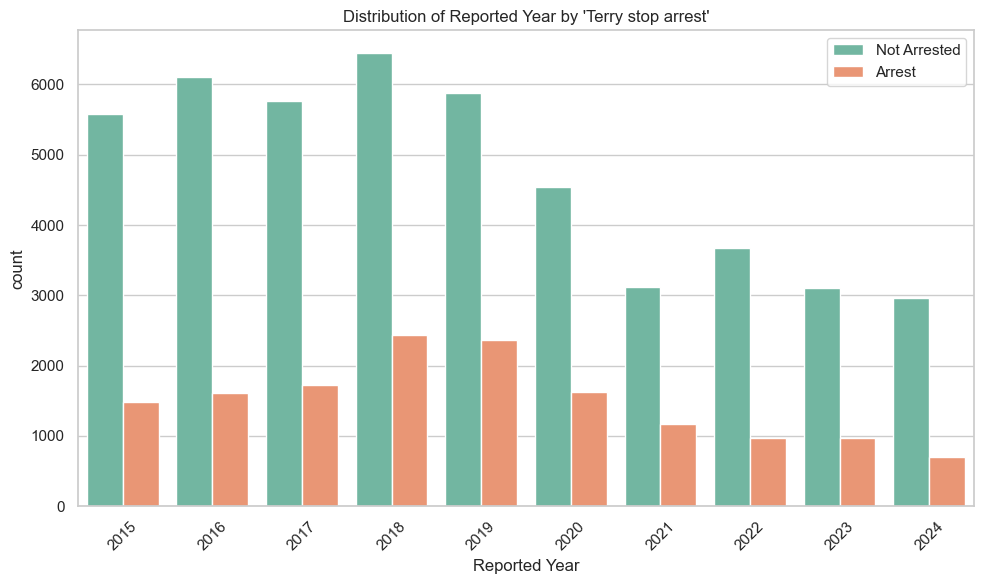

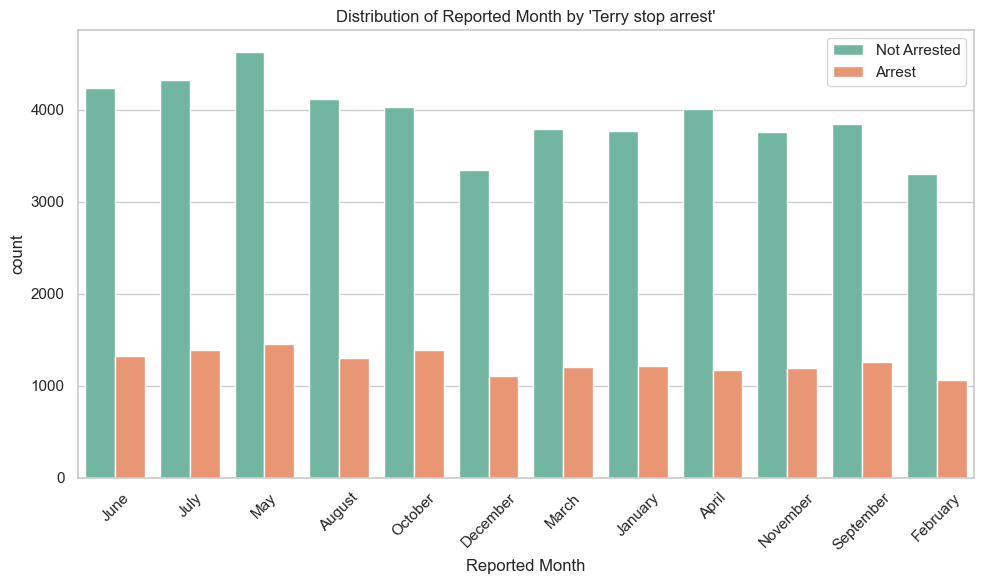

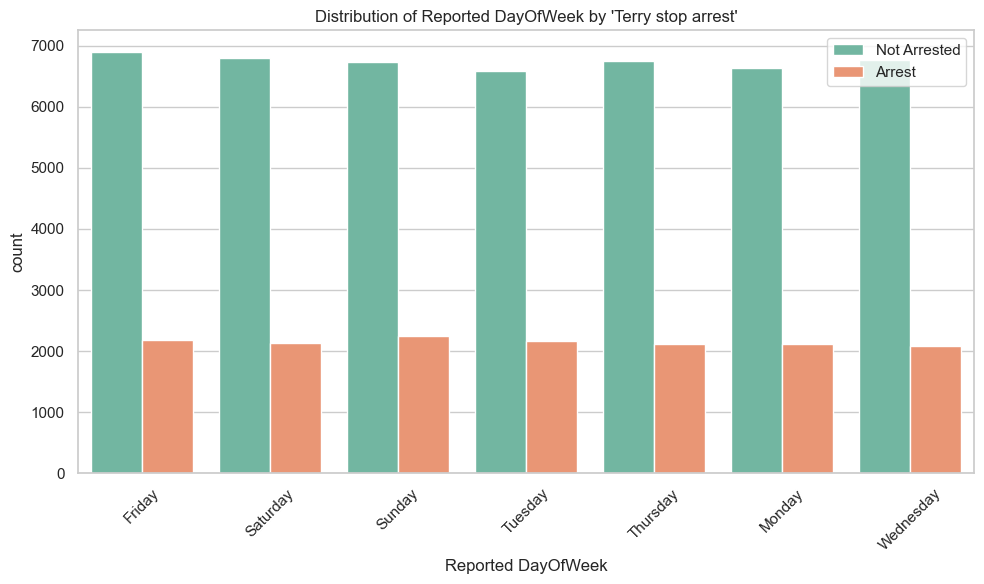

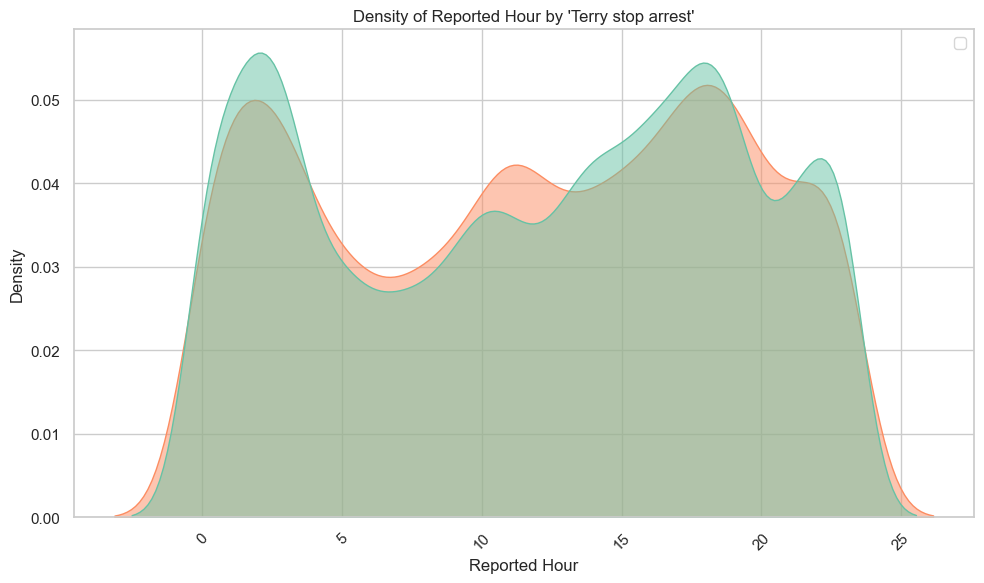

In [27]:
# Set up plotting styles
sns.set(style="whitegrid")

# Create a mapping for the legend
legend_mapping = {0: "Not Arrested", 1: "Arrest"}

# Iterate through each column to plot against 'Terry stop arrest'
for column in data.columns:
    if column != 'Terry stop arrest':
        plt.figure(figsize=(10, 6))
        
        # Check if the column is categorical or numerical
        if data[column].dtype == 'object' or data[column].nunique() < 20:
            # Plot a countplot for categorical variables
            ax = sns.countplot(
                data=data, 
                x=column, 
                hue='Terry stop arrest', 
                palette='Set2'
            )
            plt.title(f"Distribution of {column} by 'Terry stop arrest'")
            
            # Update legend labels
            handles, labels = ax.get_legend_handles_labels()
            ax.legend(handles, [legend_mapping[int(label)] for label in labels])
            
        else:
            # Plot a KDE plot for numerical variables
            ax = sns.kdeplot(
                data=data, 
                x=column, 
                hue='Terry stop arrest', 
                fill=True,
                common_norm=False, 
                alpha=0.5, 
                palette='Set2'
            )
            plt.title(f"Density of {column} by 'Terry stop arrest'")
            
            # Update legend labels
            handles, labels = ax.get_legend_handles_labels()
            ax.legend(handles, [legend_mapping[int(label)] for label in labels])
        
        # Improve layout
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

In [28]:
# data.drop('Terry stop arrest', axis=1).corr()

In [29]:
data.isna().sum()

Subject Age Group           0
Weapon Type                 0
Officer Gender              0
Officer Race                0
Subject Perceived Race      0
Subject Perceived Gender    0
Call Type                   0
Arrest Flag                 0
Frisk Flag                  0
Precinct                    0
Arrest Stop Resolution      0
Terry stop arrest           0
Officer Age                 0
Reported Year               0
Reported Month              0
Reported DayOfWeek          0
Reported Hour               0
dtype: int64

In [30]:
data.drop(columns=['Arrest Flag', 'Arrest Stop Resolution'], inplace=True)

In [31]:
data.to_csv('sample_analysis.csv', index= False)

python -m ipykernel install --user --name project-env --display-name "Python (project-env)"

## Modelling

In [32]:
y = data['Terry stop arrest']
X = data.drop('Terry stop arrest', axis=1)
X = pd.get_dummies(X, drop_first=True)

In [33]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state=40)

In [34]:
from sklearn.preprocessing import OneHotEncoder


ohe = OneHotEncoder()

ohe.fit(X_train)
X_train_ohe = ohe.transform(X_train).toarray()
X_test_ohe = ohe.transform(X_test).toarray()

### i. Baseline Model

In [75]:
# Initialize the logistic regression model
from sklearn.metrics import confusion_matrix


logistic_model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model on the training data
logistic_model.fit(X_train_ohe, y_train)

# Predict on the test data
y_pred = logistic_model.predict(X_test_ohe)

# Evaluate the model's performance
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

Confusion Matrix:
[[13779   434]
 [ 4009   436]]

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.97      0.86     14213
           1       0.50      0.10      0.16      4445

    accuracy                           0.76     18658
   macro avg       0.64      0.53      0.51     18658
weighted avg       0.71      0.76      0.70     18658


Accuracy Score:
0.7618715832350734


The results indicate that while the model performs well for class *0*, it struggles significantly with class *1*.
## Hypermetric tuning.


In [38]:
# Hyperparameter Tuning with Cross-Validation
logistic_model = LogisticRegression(max_iter=1000, random_state=42)

# Define hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],       # Regularization strength
    'penalty': ['l2'],                  # Regularization type (only 'l2' for default solvers like lbfgs)
    'solver': ['lbfgs', 'liblinear']    # Solvers for smaller datasets
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=logistic_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,  # 5-fold cross-validation
    verbose=1,
    n_jobs=-1
)

# Train using GridSearchCV
grid_search.fit(X_train_ohe, y_train)

# Get the best model and hyperparameters
best_model = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

# Evaluate on the test set
y_pred = best_model.predict(X_test_ohe)

# Display evaluation metrics
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Confusion Matrix:
[[13917   296]
 [ 4117   328]]

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.98      0.86     14213
           1       0.53      0.07      0.13      4445

    accuracy                           0.76     18658
   macro avg       0.65      0.53      0.50     18658
weighted avg       0.71      0.76      0.69     18658


Accuracy Score:
0.7634794726122843


## Desicion Tree and RandomForest Models

In [39]:
# Initialize models
from sklearn.tree import DecisionTreeClassifier


decision_tree = DecisionTreeClassifier(random_state=42)
random_forest = RandomForestClassifier(random_state=42)

# Define hyperparameter grids
data_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
}

rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

# Perform GridSearchCV for Decision Tree
data_grid_search = GridSearchCV(
    estimator=decision_tree,
    param_grid=data_param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)
data_grid_search.fit(X_train_ohe, y_train)
best_data_model = data_grid_search.best_estimator_
print(f"Best Parameters for Decision Tree: {data_grid_search.best_params_}")

# Perform GridSearchCV for Random Forest
rf_grid_search = GridSearchCV(
    estimator=random_forest,
    param_grid=rf_param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)
rf_grid_search.fit(X_train_ohe, y_train)
best_rf_model = rf_grid_search.best_estimator_
print(f"Best Parameters for Random Forest: {rf_grid_search.best_params_}")

# Evaluate models on the test set
models = {
    "Logistic Regression": best_model,  # From previous step
    "Decision Tree": best_data_model,
    "Random Forest": best_rf_model
}

for model_name, model in models.items():
    print(f"\n===== {model_name} =====")
    y_pred = model.predict(X_test_ohe)
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("\nAccuracy Score:")
    print(accuracy_score(y_test, y_pred))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters for Decision Tree: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2}
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters for Random Forest: {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}

===== Logistic Regression =====
Confusion Matrix:
[[13917   296]
 [ 4117   328]]

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.98      0.86     14213
           1       0.53      0.07      0.13      4445

    accuracy                           0.76     18658
   macro avg       0.65      0.53      0.50     18658
weighted avg       0.71      0.76      0.69     18658


Accuracy Score:
0.7634794726122843

===== Decision Tree =====
Confusion Matrix:
[[14197    16]
 [ 4428    17]]

Classification Report:
              precision    recall  f1-score   support

           0       0.76      1.

## Model evaluation

### Evaluation of Models for Predicting Arrests After a Terry Stop
#### The goal of the analysis was to build classifiers to predict whether an arrest was made after a Terry Stop. Three models were evaluated: Logistic Regression, Decision Tree, and Random Forest. Below is a summary of the evaluation and recommendations:

**Model Performance Analysis** 

1. **Logistic Regression**
    - **Confusion Matrix:**
    - Predicted well for non-arrest cases (True Negatives: 14,043) but struggled significantly with arrest cases (True Positives: 195).
    - High false negative rate indicates difficulty in identifying arrests.

    - **Metrics:**

    - Precision (Arrest): 0.53
    - Recall (Arrest): 0.04
    - F1-Score (Arrest): 0.08
    - Accuracy: 76.3%
    - Macro Avg F1-Score: 0.47

    - **Insights:**
    - The model is biased towards predicting non-arrest outcomes. Despite high overall accuracy (driven by non-arrest predictions), its ability to detect arrests is inadequate.

2. **Decision Tree**
    - **Confusion Matrix:**
    - Almost perfect classification for non-arrest cases (True Negatives: 14,206), but nearly no capability to classify arrests correctly (True Positives: 5).
    - False negatives dominate arrest cases.

    - **Metrics:**

    - Precision (Arrest): 0.42
    - Recall (Arrest): 0.00
    - F1-Score (Arrest): 0.00
    - Accuracy: 76.2%
    - Macro Avg F1-Score: 0.43
    - **Insights:**
    - The Decision Tree model has very low utility for predicting arrests. Its focus on maximizing accuracy for non-arrest cases leads to a failure to identify arrests.

3. **Random Forest**
    - **Confusion Matrix:**
    - Improved balance between non-arrest (True Negatives: 13,790) and arrest predictions (True Positives: 644).
    Reduction in false negatives for arrest cases compared to Logistic Regression and Decision Tree.

    - **Metrics:**

    - Precision (Arrest): 0.60
    - Recall (Arrest): 0.14
    - F1-Score (Arrest): 0.23
    - Accuracy: 77.4%
    - Macro Avg F1-Score: 0.55
- **Insights:**
    - Random Forest shows the best performance among the three models in terms of predicting arrests. It reduces false negatives and achieves a reasonable precision for arrests, although recall remains low.

